<a href="https://colab.research.google.com/github/sdam-au/modelling_temporal_uncertainty/blob/master/scripts/TEMPORAL-DISTRIBUTIONS_minimal-examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling ranges

## Trapezoidal distribution


As a minimal example, let's assume that we have datation "4th c. BC".
As a first step, we have to operationalize its start and stop points:

In [0]:
start = -400
stop = -301

 Further,  I assume that the the probability that the object emerged in 385 BC, 350 BC or 320 BC is **approximately equal** . 
At the same time, it is **less likely** that the  object emerged in the first or last decade of the century, since this would be probably coded in another way (e.g. "beginning of the 4th c. BC" etc.).

It seems that the best way how to model this is through a [trapezoidal distrubution](https://en.wikipedia.org/wiki/Trapezoidal_distribution).

In Python, trapezoidal distribution is implemented in SciPy library as [scipy.stats.trapz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.trapz.html). 


In [11]:
from scipy.stats import trapz
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We will use this function as a core for our function optimized for working with date ranges

In [0]:
def dist_range(start, stop, size=1, bending_point_b=0.1):
  """
  get random numbers of size size ib on the basis of start date and end date and trapezoid distribution defined by first turn point (lower bound)
  """
  r = trapz.rvs(bending_point_b, 1-bending_point_b, size=size)
  duration = abs(start-stop)
  random_values = list(((r * duration) + start).astype(int))
  if size == 1: # if only one number, return it as a number
    return random_values[0]
  else: # otherwise return a list of values
    return random_values

If we specify only start and end, it returns only one random number within the range. By default, the two bending points are configured to 0.1 and 0.9  of the duration of the function.

In [13]:
dist_range(-400, -301) # * 100) + 100

array([-320])

This way we can produce a large amount of numbers for each date range in our dataset

In [0]:
raw_date = "4th c. BC"
start = -400
stop = -301
n_of_iterations = 5000
iters = dist_range(start, stop, n_of_iterations)

For one date range, the resulting distrubution might be visualized by means of a histogram:

(-400.0, -301.0)

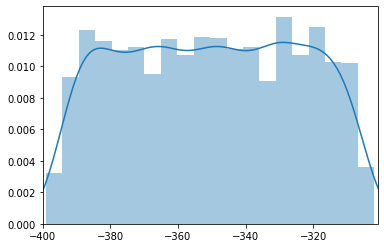

In [15]:
sns.distplot(iters, bins=20)
plt.xlim(start, stop)

# Modelling ante quem & post quem

A very common way of dating in our dataset is using **ante quem** (before that date) and **post quem** (after that date).

Again, here we have to ask about the shape of the distribution we want to model.

## a) Trapezoidal
One option is to approach it the same way as ranges, as a combination of uniform and triangular distribution. We can use our code for trapezoidal distrubution and just set up *a* = *b*, i.e. that the lower bound equals to the first bending point.  

In [0]:
def dist_ante_post(date, date_type, size=1, duration=100):
  """
  get random numbers of size size ib on the basis of start date and end date and trapezoid distribution defined by first turn point (lower bound)
  """
  if "post" in date_type:
    r = trapz.rvs(0, 0.50, size=size)
    return ((r * duration) + date).astype(int)
  if "ante" in date_type:
    r = trapz.rvs(0.50, 1, size=size)
    return ((r * duration) + date).astype(int)

Test with "post 250 AD"

In [17]:
dist_ante_post(250, "post")

array([253])

In [0]:
iters = dist_ante_post(250, "post", 5000)

(250.0, 350.0)

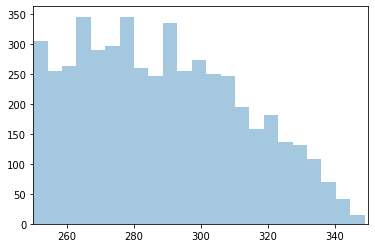

In [19]:
sns.distplot(iters, kde=False) # alternatively: hist=False
plt.xlim(250, 350)

## b) Half-normal distribution

Perhaps a better model would be a normal distribution with rather long tail



In [0]:
from scipy.stats import halfnorm

Here we can especially play with the `scale` parameter.



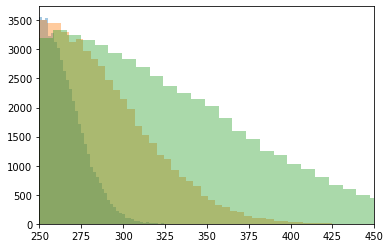

In [21]:
for scale in [20, 50, 100]:
  r = halfnorm.rvs(250, scale, 50000)
  sns.distplot(r, kde=False)
  plt.xlim(250, 450)

`scale`=50 appears to be very useful for applications where centuries are common, like PHI or EDH. So let's implement it to our model as default value.

In [0]:
def dist_ante_post(date, date_type, size=1, scale=50):
  """
  get random numbers of size size ib on the basis of start date and end date and trapezoid distribution defined by first turn point (lower bound)
  """
  if "post" in date_type:
    r = halfnorm.rvs(date, scale, size)
    return r.astype(int)
  if "ante" in date_type:
    r = halfnorm.rvs(scale=scale, size=size)
    return (date - r).astype(int)

In [23]:
# simple test with "post"
dist_ante_post(250, "post", 10)

array([299, 275, 308, 276, 291, 275, 269, 289, 281, 375])

In [24]:
# simple test with "ante"
dist_ante_post(250, "ante", 10)

array([206, 171, 228, 246, 242, 175, 202, 244, 248, 225])

Now we can test fully our ante quem

(1.0, 250.0)

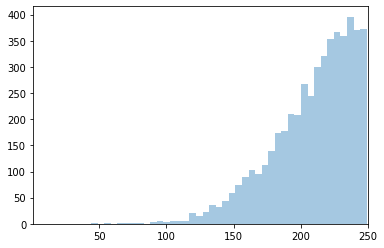

In [25]:
r = dist_ante_post(250, "ante", 5000) 
sns.distplot(r, kde=False)
plt.xlim(1, 250)

# Test with some dataset

In [0]:
import pandas as pd

In [4]:
!pip install sddk
import sddk

In [5]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ··········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


Now let's define two crucial functions:
The first produces a new column in our dataframe, which contain random numbers within a range of specified start and stop date columns, following the trapezoidal distribution.

The second function then approach this column and extract values from it

In [0]:
def model_date(start, stop, size=1):
  try:
    return dist_range(int(start), int(stop), size=size)
  except:
    return None

def get_number(row, n):
  try:
    return row["randoms"][n]
  except:
    return None

## a) Test with mounds

In [0]:
AOR_df = sddk.read_file("SDAM_data/mounds/AOR_df.json", "df", conf)
Izvestia_df = sddk.read_file("SDAM_data/mounds/Izvestia_df.json", "df", conf)

In [103]:
AOR_df.head(5)

,MoundID,Municipality,Region,Lat,Long,Error radius(m),LU_Around,MoundCover,Geomorphology,Prominence,MoundName,HeightMax,HeightMin,DiameterMax,DiameterMin,GT,RT,Condition,Source of Impact,NumberOfBurialsInside,FirstStartDate,FirstEndDate,MaxEndDate,FirstChronologyRating,FirstEnclosureType,Graves,FirstBurialNumber,GraveRankSymbols,AllDates,TotalBurialNumber,BurialAttributesAggr
0,1107,Sliven,Sliven,42.491623,26.269778,0,Annual agriculture,No data,hillside,"somewhat prominent (on a plateau, slope or spu...",no name,5.6,1.6,36,34,,Y,2 - partially damaged (type of damage is descr...,looting,10,0.0,100.0,400.0,2 - specialist consulted on a single item,,10,1,"[0, 1]","[[0.0, 100.0], [0.0, 100.0], [0.0, 100.0], [0....",10.0,"{'0': {'index': 743, 'MoundID': 1107, 'Name': ..."
1,1179,Belitsa,Blagoevgrad,41.935714,23.573565,0,Pasture (grassland),Pasture (grassland),on the ridge,very (on an outcrop or peak),Mogilata sas sarkofaga,7,,30,,,N,"1 - pristine, (only superficial or minor damag...",,1,-400.0,-300.0,-300.0,2 - specialist consulted on a single item,Cist grave,1,1,[2],"[[-400.0, -300.0]]",1.0,"{'0': {'index': 1190, 'MoundID': 1179, 'Name':..."
2,1392,Belitsa,Blagoevgrad,41.919751,23.572341,0,No data,No data,on the ridge,"somewhat prominent (on a plateau, slope or spu...",Golyamata mogila,4,,30,25,,N,"1 - pristine, (only superficial or minor damag...",,1,NaN,NaN,NaN,0 - no chronology,Simple pit,1,1,[0],"[[None, None]]",1.0,"{'0': {'index': 1992, 'MoundID': 1392, 'Name':..."
3,1393,Blagoevgrad,Blagoevgrad,41.976922,23.093051,100,Scrub,No data,hilltop,very (on an outcrop or peak),Kaymenska chuka,,,,,,Y,2 - partially damaged (type of damage is descr...,looting,4,200.0,300.0,300.0,1 - rough estimate by author on basis of the a...,Tiled grave,4,1,[0],"[[200.0, 300.0], [200.0, 300.0], [200.0, 300.0...",4.0,"{'0': {'index': 1993, 'MoundID': 1393, 'Name':..."
4,1012,Primorsko,Burgas,42.277825,27.726949,200,Forest,Forest,"valley bottom, or flat ground","not prominent (in a valley, plain or depression)",Chenger 1,3.25,2.98,28.6,26.8,,N,"1 - pristine, (only superficial or minor damag...",,2,-400.0,-200.0,-200.0,1 - rough estimate by author on basis of the a...,Simple pit,2,1,"[2, 1]","[[-400.0, -200.0], [None, None]]",2.0,"{'0': {'index': 120, 'MoundID': 1012, 'Name': ..."


In [0]:
AOR_df["randoms"] = AOR_df.apply(lambda row: model_date(row["FirstStartDate"], row["FirstEndDate"], size=1000), axis=1)
Izvestia_df["randoms"] = Izvestia_df.apply(lambda row: model_date(row["FirstStartDate"], row["FirstEndDate"], size=1000), axis=1)

In [117]:
AOR_df["FirstStartDate"].min()

-3500.0

In [118]:
AOR_df["FirstEndDate"].max()

1850.0

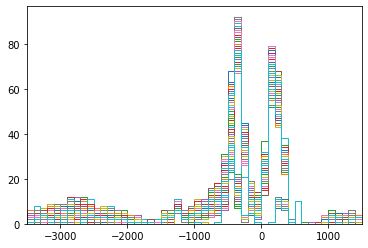

In [125]:
step = 100
bin_ranges=[n for n in range(-3500, 1500 + step, step)]
for n in range(len(AOR_df.iloc[0]["randoms"])): # for each number in lenght of our random numbers
  dates_variant = AOR_df.apply(lambda row: get_number(row, n), axis=1)
  plt.hist(dates_variant, bins=bin_ranges, histtype='step', stacked=True, fill=False)
  plt.xlim(-3500, 1500)

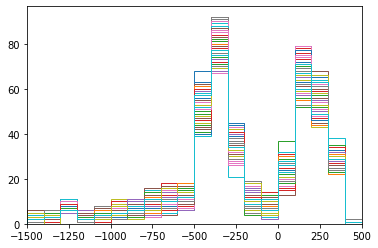

In [129]:
step = 100
bin_ranges=[n for n in range(-3500, 1500 + step, step)]
for n in range(len(AOR_df.iloc[0]["randoms"])): # for each number in lenght of our random numbers
  dates_variant = AOR_df.apply(lambda row: get_number(row, n), axis=1)
  plt.hist(dates_variant, bins=bin_ranges, histtype='step', stacked=True, fill=False)
  plt.xlim(-1500, 500)

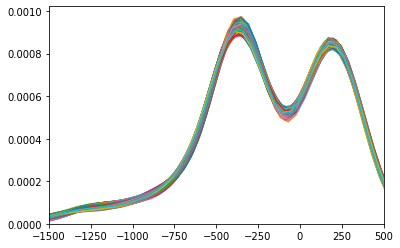

In [131]:
bin_ranges=[n for n in range(-1500, 500 + step, step)]
for n in range(len(AOR_df.iloc[0]["randoms"])): # for each number in lenght of our random numbers
  dates_variant = AOR_df.apply(lambda row: get_number(row, n), axis=1)
  sns.distplot(dates_variant, hist=False)
  plt.xlim(-1500, 500)

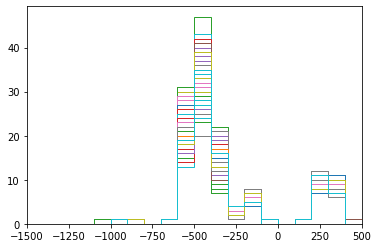

In [128]:
bin_ranges=[n for n in range(-1500, 500 + step, step)]
for n in range(len(Izvestia_df.iloc[0]["randoms"])): # for each number in lenght of our random numbers
  dates_variant = Izvestia_df.apply(lambda row: get_number(row, n), axis=1)
  plt.hist(dates_variant, bins=bin_ranges, histtype='step', stacked=True, fill=False)
  plt.xlim(-1500, 500)

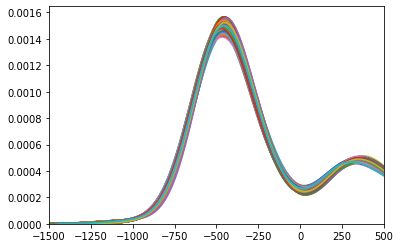

In [130]:
bin_ranges=[n for n in range(-1500, 500 + step, step)]
for n in range(len(Izvestia_df.iloc[0]["randoms"])): # for each number in lenght of our random numbers
  dates_variant = Izvestia_df.apply(lambda row: get_number(row, n), axis=1)
  sns.distplot(dates_variant, hist=False)
  plt.xlim(-1500, 500)

## b) Test with EDH

In [0]:
# read the EDH dataset from sciencedata.dk
EDH = sddk.read_file("SDAM_data/EDH/EDH_cleaned.json", "df", conf)

In [0]:
def lists_to_values(list_or_value):
  if isinstance(list_or_value, list):
    value = list_or_value[0]
  else: 
    value = list_or_value
  return value
for column in EDH.columns:
  EDH[column] = EDH.apply(lambda row: lists_to_values(row[column]), axis=1)

In [8]:
EDH.head(5)

,diplomatic_text,literature,trismegistos_uri,id,findspot_ancient,not_before,type_of_inscription,work_status,edh_geography_uri,not_after,country,province_label,transcription,material,height,width,findspot_modern,depth,commentary,uri,responsible_individual,last_update,language,modern_region,letter_size,type_of_monument,people,year_of_find,findspot,present_location,external_image_uris,religion,fotos,geography,military,social_economic_legal_history,coordinates,text_cleaned,origdate_text,objecttype,province_label_clean,province_label_certainty,type_of_inscription_clean,type_of_inscription_certainty,material_clean,height_cm,width_cm,depth_cm,type_of_monument_clean,type_of_monument_certainty,findspot_ancient_clean,findspot_ancient_certainty,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence
0,D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...,"AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...",https://www.trismegistos.org/text/251193,HD000001,"Cumae, bei",0071,epitaph,provisional,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0130,Italy,Latium et Campania (Regio I),D(is) M(anibus) / Noniae P(ubli) f(iliae) Opta...,"Marmor, geädert / farbig",33 cm,34 cm,"Cuma, bei",2.7 cm,(C): 2. Hälfte 1. - Anfang 2. Jh. - AE; Ende ...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Campania,3.2-2 cm,tabula,"{'cognomen': 'Optata', 'person_id': '1', 'gend...",{},{},{},{},{},{},{},{},{},"40.8471577,14.0550756",Dis Manibus Noniae Publi filiae Optatae et Cai...,71 AD – 130 AD,Tafel,Latium et Campania (Regio I),Certain,epitaph,Certain,Marble,33.0,34.0,2.7,tabula,Certain,Cumae,Estimated,D M Noniae P f Optatae et C Iulio Artemoni par...,Dis Manibus Noniae Publi filiae Optatae et Cai...,Dis Manibus Noniae Publi filiae Optatae et Cai...
1,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",https://www.trismegistos.org/text/265631,HD000002,Roma,0051,epitaph,no image,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Italy,Roma,C(aius) Sextius Paris / qui vixit / annis LXX,marble: rocks - metamorphic rocks,28 cm,85 cm,Roma,{},AE 1983: Breite: 35 cm.,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Lazio,4 cm,tabula,"{'age: years': '70', 'cognomen': 'Paris', 'gen...",1937,"Via Nomentana, S. Alessandro, Kirche",{},{},{},{},{},{},{},"41.895466,12.482324",Caius Sextius Paris qui vixit annis LXX ...,51 AD – 200 AD,Tafel,Roma,Certain,epitaph,Certain,Marble,28.0,85.0,NaN,tabula,Certain,Roma,Certain,C Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX
2,[ ]VMMIO [ ] / [ ]ISENNA[ ] / [ ] XV[ ] / [ ] / [,"AE 1983, 0518. (B); J. González, ZPE 52, 1983,...",https://www.trismegistos.org/text/220675,HD000003,{},0131,honorific inscription,provisional,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0170,Spain,Baetica,[P(ublio) M]ummio [P(ubli) f(ilio)] / [Gal(eri...,marble: rocks - metamorphic rocks,(37) cm,(34) cm,Tomares,(12) cm,(B): [S]isenna ist falscher Kasus; folgende E...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2006-08-31,Latin,Sevilla,4.5-3 cm,statue base,"{'nomen': 'Mummius+', 'cognomen': 'Sisenna+ Ru...",before 1975,{},"Sevilla, Privatbesitz",{},{},{},{},{},{},"37.37281,-6.04589",Publio Mummio Publi filio Galeria Sisennae Rut...,131 AD – 170 AD,Statuenbasis,Baetica,Certain,honorific inscription,Certain,Marble,37.0,34.0,12.0,statue base,Certain,NULL,NULL,ummio isenna Xv,Publio Mummio Publi filio Galeria Sisennae Rut...,Publio Mummio Publi filio Galeria Sisennae Rut...
3,[ ]AVS[ ]LLA / M PORCI NIGRI SER / DOMINAE VEN...,"AE 1983, 0533. (B); A.U. Stylow, Gerión 1, 198...",https://www.trismegistos.org/text/222102,HD000004,Ipolcobulcula,0151,votive inscription,checked with photo,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Spain,Baetica,[---?]AV(?)S(?)[---]L(?)L(?)A / M(arci) Porci ...,limestone: rocks - clastic sediments,(39) cm,27 cm,Carcabuey,18 

In [0]:
EDH["not_after"] = pd.to_numeric(EDH["not_after"])
EDH["not_before"] = pd.to_numeric(EDH["not_before"])

In [38]:

### how many of the inscriptions have at least one date
EDH_dated = EDH[(EDH["not_before"].notnull()) | (EDH["not_after"].notnull())]
len(EDH_dated)

57782

In [45]:
len(EDH_dated[EDH_dated["not_after"].isnull()])

3457

In [73]:
EDH_dated["randoms"] = EDH_dated.apply(lambda row: model_date(row["not_before"], row["not_after"]), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [98]:
EDH_condensed = EDH_dated[["id", "not_before", "not_after", "randoms"]]
EDH_condensed.head(20)

,id,not_before,not_after,randoms
0,HD000001,71.0,130.0,"[118, 113, 126, 113, 99, 99, 90, 91, 89, 124, ..."
1,HD000002,51.0,200.0,"[105, 142, 84, 65, 90, 105, 102, 165, 95, 148,..."
2,HD000003,131.0,170.0,"[157, 136, 135, 132, 151, 160, 145, 133, 146, ..."
3,HD000004,151.0,200.0,"[175, 172, 161, 164, 154, 181, 177, 165, 178, ..."
4,HD000005,1.0,200.0,"[155, 103, 182, 110, 20, 145, 180, 85, 118, 14..."
5,HD000006,71.0,150.0,"[134, 130, 142, 122, 107, 146, 80, 128, 99, 10..."
6,HD000007,-100.0,-51.0,"[-58, -91, -76, -59, -65, -61, -80, -66, -69, ..."
7,HD000008,101.0,200.0,"[154, 123, 117, 114, 162, 144, 165, 109, 161, ..."
8,HD000009,201.0,300.0,"[212, 244, 263, 288, 271, 211, 284, 276, 245, ..."
9,HD000010,101.0,200.0,"[180, 133, 156, 146, 197, 151, 126, 131, 170, ..."


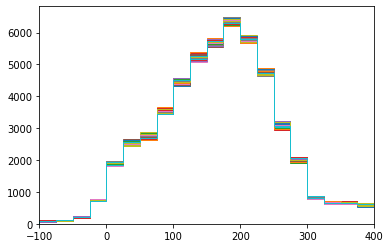

In [95]:
def get_number(row, n):
  try:
    return row["randoms"][n]
  except:
    return None

step = 25
bin_ranges=[n for n in range(-100, 400 + step, step)]
for n in range(len(EDH_dated.iloc[0]["randoms"])): # for each number in lenght of our random numbers
  dates_variant = EDH_dated.apply(lambda row: get_number(row, n), axis=1)
  plt.hist(dates_variant, bins=bin_ranges, histtype='step', stacked=True, fill=False)
  plt.xlim(-100, 400)


(-100.0, 400.0)

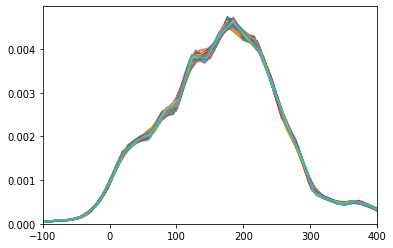

In [99]:
for n in range(100):
  dates_variant = EDH_condensed.apply(lambda row: get_number(row, n), axis=1)
  sns.distplot(dates_variant, hist=False)
plt.xlim(-100, 400)